# __Quality Assesment Notebook__

The goal of this notebook is to produce a series of plots
assesing the quality of the mocks

In [278]:
import fitsio
import glob
import matplotlib.pyplot as plt
import scipy as sp
import scipy.random
from scipy.interpolate import interp1d
import healpy

Set up the different path to the data and to the mocks

In [279]:
### Get mocks
mock_base = '/project/projectdirs/desi/mocks/lya_forest/london/v4.0/'
quick_ver = 'quick-0.0'

In [327]:
### Get mock products
mock = {}
mock['delta'] = '/project/projectdirs/desi/mocks/lya_forest/picca/london/v4.0/quick-0.0/deltas/'
mock['delta_attributes'] = '/project/projectdirs/desi/mocks/lya_forest/picca/london/v4.0/quick-0.0/iter.fits.gz'
mock['delta_log'] = '/project/projectdirs/desi/mocks/lya_forest/picca/london/v4.0/quick-0.0/input.log'
mock['cf1d'] = '/global/homes/h/hdumasde/Run_programs/igmhub/picca/CoLoRe_mocks/cf1d.fits.gz'

In [303]:
### Get data products
data = {}
data['delta'] = '/global/homes/h/hdumasde/Run_programs/igmhub/picca/DR14_results/Delta_LYA/Delta/'
data['delta_attributes'] = '/global/homes/h/hdumasde/Run_programs/igmhub/picca/DR14_results/Delta_LYA/Log/delta_attributes.fits.gz'
data['cf1d'] = '/global/homes/h/hdumasde/Run_programs/igmhub/picca/DR14_results/Correlations/cf1d.fits.gz'

# __Catalogs__

In [373]:
# Catalogs
cat_path = {'master':mock_base+'master.fits',
            'zcat':mock_base+quick_ver+'/zcat.fits',
            'desiDRQ':mock_base+quick_ver+'/zcat_desi_drq.fits',
            'random':mock_base+'/randoms_lya_london_v4.fits.gz'}
redshift_key = {'master':'Z_QSO_RSD', 'zcat':'Z', 'desiDRQ':'Z','random':'Z'}

### Let's plot the redshift distribution of the different catalogs

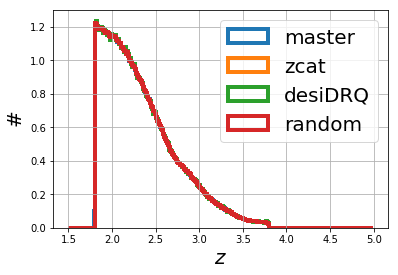

In [374]:
bins = sp.arange(1.5,5.,0.01)
for name,path in cat_path.items():
    h = fitsio.FITS(path)
    z = h[1][redshift_key[name]][:]
    h.close()
    plt.hist(z,bins=bins,histtype='step',label=name,density=True,linewidth=4)
plt.xlabel(r'$z$',fontsize=20)
plt.ylabel(r'$\mathrm{\#}$',fontsize=20)
plt.legend(fontsize=20)
plt.grid()
plt.show()

### Let's plot the distribution of the objects on the sky

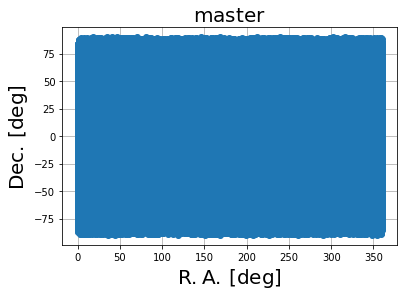

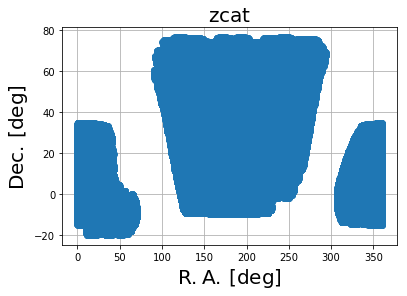

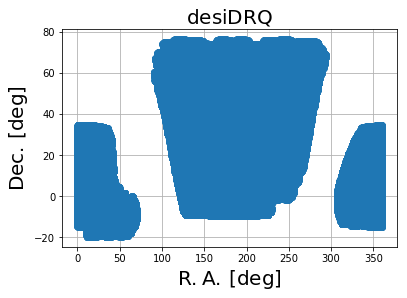

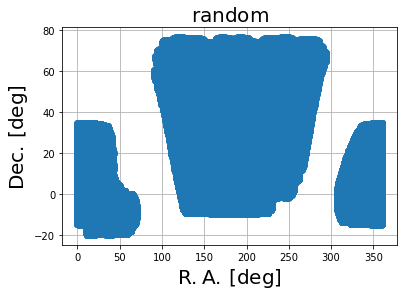

In [380]:
sp.random.seed(42)
for name,path in cat_path.items():
    h = fitsio.FITS(path)
    ra = h[1]['RA'][:]
    dec = h[1]['DEC'][:]
    w = sp.random.choice(sp.arange(ra.size,dtype=int),size=min(ra.size,1000000),replace=False)
    ra = ra[w]
    dec = dec[w]
    h.close()
    plt.errorbar(ra,dec,fmt='o')
    plt.xlabel(r'$\mathrm{R.A. \, [deg]}$',fontsize=20)
    plt.ylabel(r'$\mathrm{Dec. \, [deg]}$',fontsize=20)
    plt.title(r'$\mathrm{'+name+'}$',fontsize=20)
    plt.grid()
    plt.show()

#### The following function allows to have a 2d histogram

In [381]:
def Get_2DTProfile(ar1, ar2, ar3, nbBinsX, nbBinsY,we=None):

    if we is None:
        we = sp.ones_like(ar1)
    d = sp.array(list(zip(ar1,ar2,ar3)))
    number, axis = sp.histogramdd( d, (nbBinsX,nbBinsY,1))
    weight, axis = sp.histogramdd( d, (nbBinsX,nbBinsY,1), weights=we  )
    mean,   axis = sp.histogramdd( d, (nbBinsX,nbBinsY,1), weights=we*ar3)
    err,    axis = sp.histogramdd( d, (nbBinsX,nbBinsY,1), weights=we*(ar3**2.))

    w = number>1
    mean[w]   /= weight[w]
    err[w]    = sp.sqrt((err[w]/weight[w]-mean[w]**2.)/number[w])

    mean   = mean[:,:,0]
    err    = err[:,:,0]
    number = number[:,:,0]

    return mean, err, number

### Let's look at the number of objects on the sky

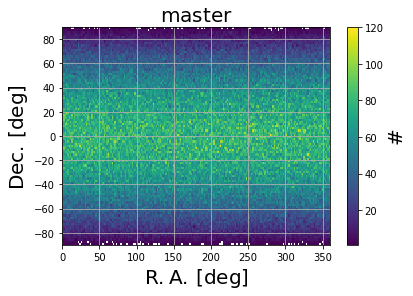

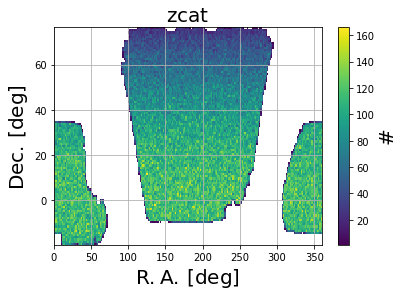

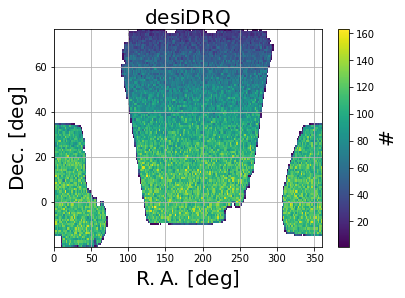

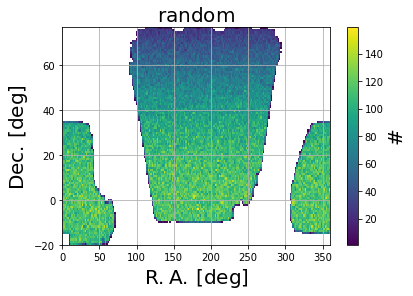

In [382]:
sp.random.seed(42)
for name,path in cat_path.items():
    h = fitsio.FITS(path)
    ra = h[1]['RA'][:]
    dec = h[1]['DEC'][:]
    w = sp.random.choice(sp.arange(ra.size,dtype=int),size=min(ra.size,1000000),replace=False)
    ra = ra[w]
    dec = dec[w]
    h.close()
    extent = [ra.min(), ra.max(), dec.min(), dec.max()]
    mean, err, number = Get_2DTProfile(ra, dec, sp.ones(ra.size), 200, 100)
    number = sp.transpose(number)
    number[number==0.] = sp.nan
    plt.imshow(number, interpolation='nearest', origin='lower',extent=extent, aspect='auto')
    cbar = plt.colorbar()
    cbar.set_label(r'$\#$',size=20)
    cbar.update_ticks()
    plt.xlabel(r'$\mathrm{R.A. \, [deg]}$',fontsize=20)
    plt.ylabel(r'$\mathrm{Dec. \, [deg]}$',fontsize=20)
    plt.title(r'$\mathrm{'+name+'}$',fontsize=20)
    plt.grid()
    plt.show()

### Let's look at the redshift across the sky

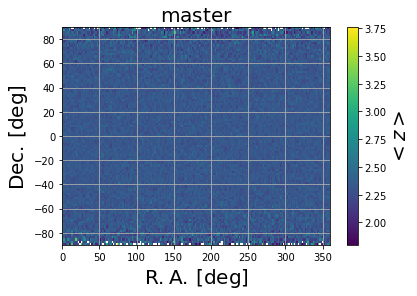

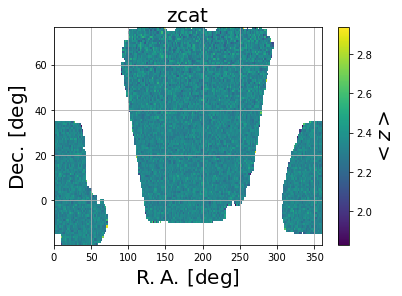

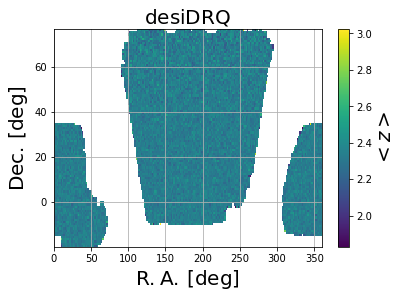

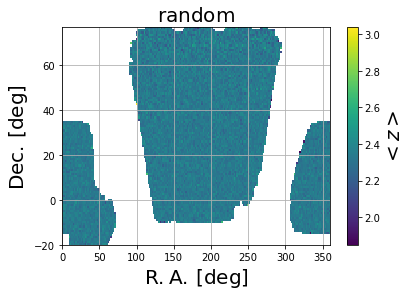

In [383]:
sp.random.seed(42)
for name,path in cat_path.items():
    h = fitsio.FITS(path)
    ra = h[1]['RA'][:]
    dec = h[1]['DEC'][:]
    z = h[1][redshift_key[name]][:]
    w = sp.random.choice(sp.arange(ra.size,dtype=int),size=min(ra.size,1000000),replace=False)
    ra = ra[w]
    dec = dec[w]
    z = z[w]
    h.close()
    extent = [ra.min(), ra.max(), dec.min(), dec.max()]
    mean, err, number = Get_2DTProfile(ra, dec, z, 200, 100)
    mean = sp.transpose(mean)
    number = sp.transpose(number)
    mean[number==0.] = sp.nan
    plt.imshow(mean, interpolation='nearest', origin='lower',extent=extent, aspect='auto')
    cbar = plt.colorbar()
    cbar.set_label(r'$<z>$',size=20)
    cbar.update_ticks()
    plt.xlabel(r'$\mathrm{R.A. \, [deg]}$',fontsize=20)
    plt.ylabel(r'$\mathrm{Dec. \, [deg]}$',fontsize=20)
    plt.title(r'$\mathrm{'+name+'}$',fontsize=20)
    plt.grid()
    plt.show()

### Let's look at the magnitude distribution

In [241]:
name_mag = {}
name_mag[0] = 'g mag: decam'
name_mag[1] = 'r mag: decam'
name_mag[2] = 'z mag: decam'
name_mag[3] = 'wise1'
name_mag[4] = 'wise2'

In [242]:
h = fitsio.FITS(cat_path['zcat'])
mag = h['ZCATALOG']['MAG'][:]
z = h['ZCATALOG']['Z'][:]
ra = h['ZCATALOG']['RA'][:]
dec = h['ZCATALOG']['DEC'][:]
h.close()

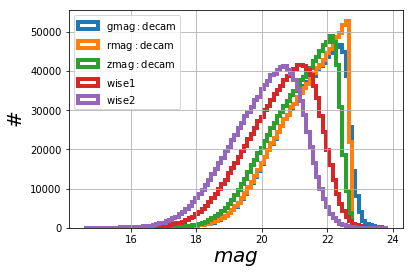

In [243]:
bins = sp.arange(mag.min(), mag.max(), 0.1)
for i in range(5):
    plt.hist(mag[:,i],bins=bins,linewidth=4,histtype='step',label=r'$\mathrm{'+name_mag[i]+'}$')
plt.xlabel(r'$mag$',fontsize=20)
plt.ylabel(r'$\#$',fontsize=20)
plt.legend(fontsize=10,loc=2)
plt.grid()
plt.show()

#### The following function allows to get the profile

In [244]:
def Get_TProfile(ar1, ar2, nbBin1, we2=None):

    if we2 is None:
        we2 = sp.ones_like(ar1)
    number, axisX, axisY = sp.histogram2d(ar1, ar2, (nbBin1,1))
    weight, axisX, axisY = sp.histogram2d(ar1, ar2, (nbBin1,1), weights=we2)
    mean,   axisX, axisY = sp.histogram2d(ar1, ar2, (nbBin1,1), weights=we2*ar2)
    err,    axisX, axisY = sp.histogram2d(ar1, ar2, (nbBin1,1), weights=we2*(ar2**2.))

    ### find the axis X
    axisX = sp.array([ axisX[i]+(axisX[i+1]-axisX[i])/2. for i in range(0,axisX.size-1) ])
    
    ### Get only not empty bins
    bool_number = (number[:,0]>1)
    
    axisX  = axisX[bool_number]
    number = number[:,0][bool_number]
    weight = weight[:,0][bool_number]
    mean   = mean[:,0][bool_number]
    err    = err[:,0][bool_number]

    mean  = mean/weight
    err   = sp.sqrt((err/weight-mean**2.)/number)

    return axisX, mean, err, number

### Let's look at the evolution of magnitude with redshift

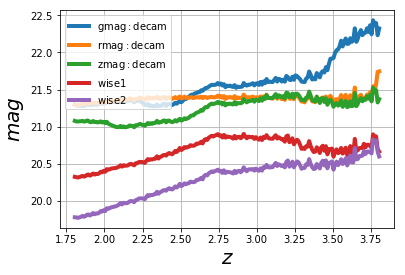

In [245]:
bins = sp.arange(1.5, 5., 0.01)
for i in range(5):
    axisX, mean, err, number = Get_TProfile(z,mag[:,i], bins)
    plt.plot(axisX, mean,linewidth=4,label=r'$\mathrm{'+name_mag[i]+'}$')
plt.xlabel(r'$z$',fontsize=20)
plt.ylabel(r'$mag$',fontsize=20)
plt.legend(fontsize=10,loc=2)
plt.grid()
plt.show()

### Let's look at the evolution of magnitude on the sky

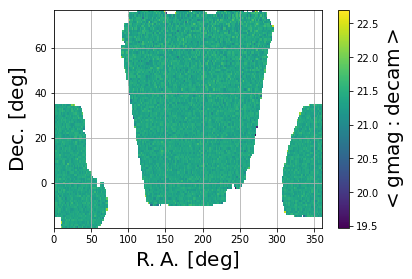

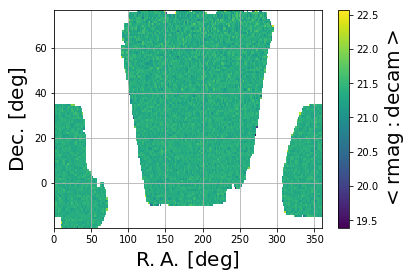

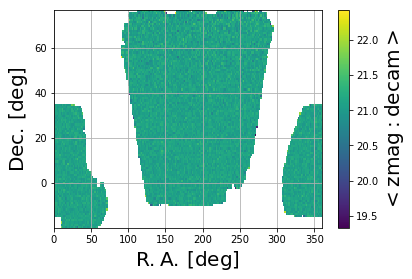

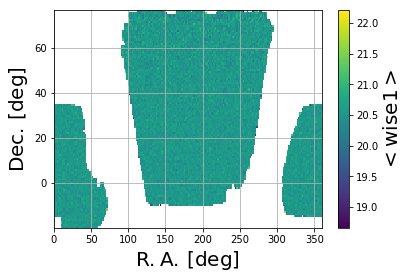

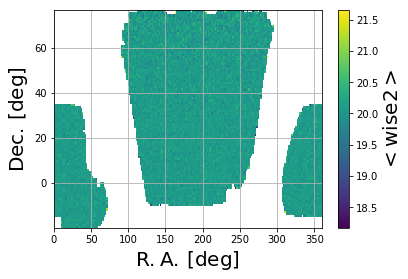

In [246]:
for i in range(5):        
    extent = [ra.min(), ra.max(), dec.min(), dec.max()]
    mean, err, number = Get_2DTProfile(ra, dec, mag[:,i], 200, 100)
    mean = sp.transpose(mean)
    number = sp.transpose(number)
    mean[number==0.] = sp.nan
    plt.imshow(mean, interpolation='nearest', origin='lower',extent=extent, aspect='auto')
    cbar = plt.colorbar()
    cbar.set_label(r'$<\mathrm{'+name_mag[i]+'}>$',size=20)
    cbar.update_ticks()
    plt.xlabel(r'$\mathrm{R.A.} \, [\mathrm{deg}]$',fontsize=20)
    plt.ylabel(r'$\mathrm{Dec.} \, [\mathrm{deg}]$',fontsize=20)
    plt.grid()
    plt.show()

# __Lya Transmission__

In [359]:
### Get all transmission files
fs = sp.sort(glob.glob(mock_base+'/*/*/transmission-*-*.fits'))
fs = fs[:10]
lLYA = 1215.67
lminforest = 1215.67

In [360]:
### Along the observed wavelength 
lObs_min = 3000.
lObs_max = 8000.
lObs_stack = sp.arange(lObs_min,lObs_max,1.)
z_stack = lObs_stack/lLYA-1.
T_stack = sp.zeros(lObs_stack.size)
TVar_stack = sp.zeros(lObs_stack.size)
n_stack = sp.zeros(lObs_stack.size)
T_stack_delta = sp.zeros(lObs_stack.size)
TVar_stack_delta = sp.zeros(lObs_stack.size)
n_stack_delta = sp.zeros(lObs_stack.size)

In [361]:
### Along the rest-frame wavelength
lRF_min = 100.
lRF_max = 4000.
lRF_stack = sp.arange(lRF_min,lRF_max,1.)
T_lRF_stack = sp.zeros(lRF_stack.size)
TVar_lRF_stack = sp.zeros(lRF_stack.size)
n_lRF_stack = sp.zeros(lRF_stack.size)
T_lRF_stack_delta = sp.zeros(lRF_stack.size)
TVar_lRF_stack_delta = sp.zeros(lRF_stack.size)
n_lRF_stack_delta = sp.zeros(lRF_stack.size)

In [362]:
### Get the transmission
for f in fs:
    h = fitsio.FITS(f)
    z = h['METADATA']['Z'][:]
    lObs = h['WAVELENGTH'].read()
    trans = h['TRANSMISSION'].read()
    lRF = lObs/(1.+z[:,None])
    lObs = lObs*sp.ones(z.size)[:,None]
    w = lRF<lminforest
    lObs = lObs[w]
    lRF = lRF[w]
    trans = trans[w]

    bins = ( ( lObs-lObs_min )/(lObs_max-lObs_min)*lObs_stack.size ).astype(int)
    T_stack += sp.bincount(bins,weights=trans,minlength=lObs_stack.size)
    TVar_stack += sp.bincount(bins,weights=trans**2,minlength=lObs_stack.size)
    n_stack += sp.bincount(bins,minlength=lObs_stack.size)

    bins = ( ( lRF-lRF_min )/(lRF_max-lRF_min)*lRF_stack.size ).astype(int)
    T_lRF_stack += sp.bincount(bins,weights=trans,minlength=lRF_stack.size)
    TVar_lRF_stack += sp.bincount(bins,weights=trans**2,minlength=lRF_stack.size)
    n_lRF_stack += sp.bincount(bins,minlength=lRF_stack.size)

In [363]:
### Normalize the vectors (obseved wavelength)
w = n_stack>0.
T_stack[w] /= n_stack[w]
TVar_stack[w] /= n_stack[w]
TVar_stack -= T_stack**2
trans_vs_lObs = interp1d(lObs_stack[w],T_stack[w],fill_value='extrapolate',kind='nearest')

### Normalize the vectors (rest-frame wavelength)
w = n_lRF_stack>0.
T_lRF_stack[w] /= n_lRF_stack[w]
TVar_lRF_stack[w] /= n_lRF_stack[w]
TVar_lRF_stack -= T_lRF_stack**2

In [364]:
### Get the delta
for f in fs:
    h = fitsio.FITS(f)
    z = h['METADATA']['Z'][:]
    lObs = h['WAVELENGTH'].read()
    trans = h['TRANSMISSION'].read()
    h.close()
    lRF = lObs/(1.+z[:,None])
    lObs = lObs*sp.ones(z.size)[:,None]
    w = lRF<lminforest
    lObs = lObs[w]
    lRF = lRF[w]
    trans = trans[w]/trans_vs_lObs(lObs)-1.

    bins = ( ( lObs-lObs_min )/(lObs_max-lObs_min)*lObs_stack.size ).astype(int)
    T_stack_delta += sp.bincount(bins,weights=trans,minlength=lObs_stack.size)
    TVar_stack_delta += sp.bincount(bins,weights=trans**2,minlength=lObs_stack.size)
    n_stack_delta += sp.bincount(bins,minlength=lObs_stack.size)

    bins = ( ( lRF-lRF_min )/(lRF_max-lRF_min)*lRF_stack.size ).astype(int)
    T_lRF_stack_delta += sp.bincount(bins,weights=trans,minlength=lRF_stack.size)
    TVar_lRF_stack_delta += sp.bincount(bins,weights=trans**2,minlength=lRF_stack.size)
    n_lRF_stack_delta += sp.bincount(bins,minlength=lRF_stack.size)

In [365]:
### Normalize the vectors (obseved wavelength)
w = n_stack_delta>0.
T_stack_delta[w] /= n_stack_delta[w]
TVar_stack_delta[w] /= n_stack_delta[w]
TVar_stack_delta -= T_stack_delta**2

### Normalize the vectors (rest-frame wavelength)
w = n_lRF_stack_delta>0.
T_lRF_stack_delta[w] /= n_lRF_stack_delta[w]
TVar_lRF_stack_delta[w] /= n_lRF_stack_delta[w]
TVar_lRF_stack_delta -= T_lRF_stack_delta**2

In [366]:
### from measurement on data
### The input mean flux that we were trying to match corresponds
### to F(z=2.25)=0.8, and a slope in optical depth of (1+z)^3.2.
A = -sp.log(0.8)/(1.+2.25)**3.2
B = 3.2
print(' optical depth = ', A, B)
T_measure = sp.exp(-A*(1.+z_stack)**B)
DVar_measure = 0.0018*(1.+z_stack)**(2.*2.9-2.)
TVar_measure = DVar_measure*T_measure**2

 optical depth =  0.005135202633916249 3.2


### Let's look at transmission as a function of redshift

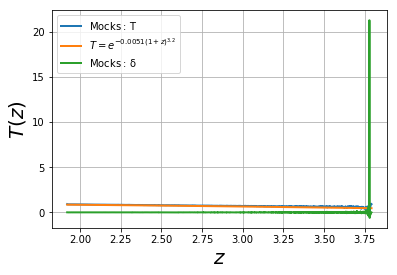

In [367]:
w = n_stack>0.
plt.plot(z_stack[w],T_stack[w],linewidth=2,label=r'$\mathrm{Mocks: \, T}$')
plt.plot(z_stack[w],T_measure[w],linewidth=2,label=r'$T = e^{-0.0051(1+z)^{3.2}}$')
w = n_stack_delta>0.
plt.plot(z_stack[w],T_stack_delta[w],linewidth=2,label=r'$\mathrm{Mocks: \, \delta}$')
plt.xlabel(r'$z$',fontsize=20)
plt.ylabel(r'$T(z)$',fontsize=20)
plt.legend(fontsize=10)
plt.grid()
plt.show()

### Let's look at the variance of the transmission as a function of redshift

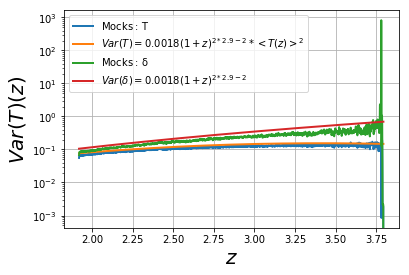

In [368]:
w = n_stack>0.
plt.plot(z_stack[w],TVar_stack[w],linewidth=2,label=r'$\mathrm{Mocks:\,T}$')
plt.plot(z_stack[w],TVar_measure[w],linewidth=2,label=r'$Var(T) = 0.0018 (1+z)^{2*2.9-2} * <T(z)>^{2}$')
w = n_stack_delta>0.
plt.plot(z_stack[w],TVar_stack_delta[w],linewidth=2,label=r'$\mathrm{Mocks:\,\delta}$')
plt.plot(z_stack[w],DVar_measure[w],linewidth=2,label=r'$Var(\delta) = 0.0018 (1+z)^{2*2.9-2}$')
plt.xlabel(r'$z$',fontsize=20)
plt.ylabel(r'$Var(T)(z)$',fontsize=20)
plt.legend(fontsize=10)
plt.yscale('log')
plt.grid()
plt.show()

### Let's look at the transmission as a function of rest-frame wavelength

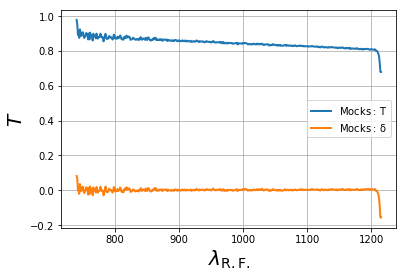

In [369]:
w = n_lRF_stack>0.
plt.plot(lRF_stack[w],T_lRF_stack[w],linewidth=2,label=r'$\mathrm{Mocks:\,T}$')
w = n_lRF_stack_delta>0.
plt.plot(lRF_stack[w],T_lRF_stack_delta[w],linewidth=2,label=r'$\mathrm{Mocks:\,\delta}$')
plt.xlabel(r'$\lambda_{\mathrm{R.F.}}$',fontsize=20)
plt.ylabel(r'$T$',fontsize=20)
plt.legend(fontsize=10)
plt.grid()
plt.show()

### Let's look at the variance of the transmission as a function of rest-frame wavelength

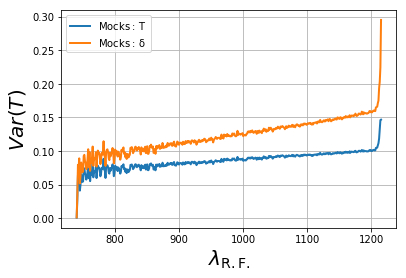

In [370]:
w = n_lRF_stack>0.
plt.plot(lRF_stack[w],TVar_lRF_stack[w],linewidth=2,label=r'$\mathrm{Mocks:\,T}$')
w = n_lRF_stack_delta>0.
plt.plot(lRF_stack[w],TVar_lRF_stack_delta[w],linewidth=2,label=r'$\mathrm{Mocks:\,\delta}$')
plt.xlabel(r'$\lambda_{\mathrm{R.F.}}$',fontsize=20)
plt.ylabel(r'$Var(T)$',fontsize=20)
plt.legend(fontsize=10)
plt.grid()
plt.show()

# __Example of a spectrum__

In [285]:
### Get the different path to spectrum
trans_path = mock_base+'/0/0/transmission-16-0.fits'
spec_path = mock_base+quick_ver+'/spectra-16/0/0/spectra-16-0.fits'

In [286]:
### Get delta nside
h = fitsio.FITS(delta_attributes)
nside = h[1].read_header()['NSIDE']
h.close()

In [287]:
### Get the spectrum
h = fitsio.FITS(spec_path)
hra = h['FIBERMAP']['RA_TARGET'][:]
hde = h['FIBERMAP']['DEC_TARGET'][:]
tid = h['FIBERMAP']['TARGETID'][:]
b_ll = sp.log10(h['B_WAVELENGTH'].read())
b_iv = h['B_IVAR'].read()*(h['B_MASK'].read()==0)
b_fl = h['B_FLUX'].read()
r_ll = sp.log10(h['R_WAVELENGTH'].read())
r_iv = h['R_IVAR'].read()*(h['R_MASK'].read()==0)
r_fl = h['R_FLUX'].read()
z_ll = sp.log10(h['Z_WAVELENGTH'].read())
z_iv = h['Z_IVAR'].read()*(h['Z_MASK'].read()==0)
z_fl = h['Z_FLUX'].read()

In [288]:
### Get Transmission
h = fitsio.FITS(trans_path)
z = h['METADATA']['Z'][:]
ra = h['METADATA']['RA'][:]
de = h['METADATA']['DEC'][:]
lObs = h['WAVELENGTH'].read()
trans = h['TRANSMISSION'].read()
h.close()
lRF = lObs/(1.+z[:,None])
lObs = lObs*sp.ones(z.size)[:,None]

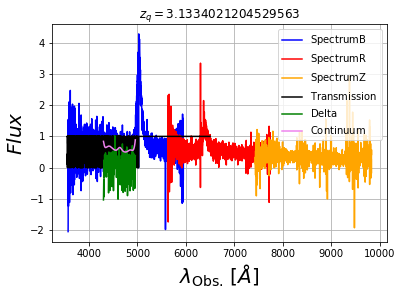

In [289]:
### Plot the first n spectra
for idx in range(1):
    ra_idx = hra[idx]
    de_idx = hde[idx]
    z_idx = z[ra==hra[idx]][0]
    tid_idx = tid[idx]

    delt_pix = healpy.ang2pix(nside, sp.pi/2.-de_idx*sp.pi/180., ra_idx*sp.pi/180.)
    delta = fitsio.FITS(mock['delta']+'/delta-'+str(delt_pix)+'.fits.gz')
    deltaa = delta[str(tid_idx)]

    nidx = sp.arange(ra.size)[ra==ra_idx][0]
    plt.plot(10**b_ll,b_fl[idx,:],color='blue',label=r'$\mathrm{Spectrum B}$')
    plt.plot(10**r_ll,r_fl[idx,:],color='red',label=r'$\mathrm{Spectrum R}$')
    plt.plot(10**z_ll,z_fl[idx,:],color='orange',label=r'$\mathrm{Spectrum Z}$')
    plt.plot(lObs[nidx,:],trans[nidx,:],color='black',label=r'$\mathrm{Transmission}$')
    plt.plot(10**deltaa['LOGLAM'][:],deltaa['DELTA'][:],color='green',label=r'$\mathrm{Delta}$')
    plt.plot(10**deltaa['LOGLAM'][:],deltaa['CONT'][:],color='violet',label=r'$\mathrm{Continuum}$')
    
    plt.title(r'$z_{q} = '+str(z[ra==hra[idx]][0])+'$')
    plt.xlabel(r'$\lambda_{\mathrm{Obs.}} \, [\AA]$',fontsize=20)
    plt.ylabel(r'$Flux$',fontsize=20)
    plt.legend(fontsize=10)
    plt.grid()
    plt.show()

# __The delta field__

To get the delta field in the Lya forest, simply run in your terminal the following
command

In [330]:
### Command to get the delta field
cmd = 'do_deltas.py'
cmd += ' --drq '+mock_base+quick_ver+'/zcat_desi_drq.fits'
cmd += ' --in-dir '+mock_base+quick_ver+'/spectra-16/'
cmd += ' --out-dir '+mock['delta']
cmd += ' --iter-out-prefix '+mock['delta_attributes']
cmd += ' --log '+mock['delta_log']
cmd += ' --mode desi'
print(cmd)

do_deltas.py --drq /project/projectdirs/desi/mocks/lya_forest/london/v4.0/quick-0.0/zcat_desi_drq.fits --in-dir /project/projectdirs/desi/mocks/lya_forest/london/v4.0/quick-0.0/spectra-16/ --out-dir /project/projectdirs/desi/mocks/lya_forest/picca/london/v4.0/quick-0.0/deltas/ --iter-out-prefix /project/projectdirs/desi/mocks/lya_forest/picca/london/v4.0/quick-0.0/iter.fits.gz --log /project/projectdirs/desi/mocks/lya_forest/picca/london/v4.0/quick-0.0/input.log --mode desi


In [331]:
### List of all the delta attributes functions to plot
all_delta_attributes = {'Mock':mock['delta_attributes'], 'Data':data['delta_attributes']}

### Let's look at the stack of the flux as a function of observed wavelength

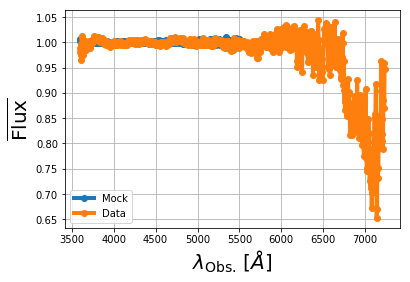

In [332]:
for name,path in all_delta_attributes.items():
    h = fitsio.FITS(path)
    loglam = h[1]['LOGLAM'][:]
    stack  = h[1]['STACK'][:]
    w = h[1]['WEIGHT'][:]>0.
    loglam = loglam[w]
    stack  = stack[w]
    plt.plot(10.**loglam, stack, linewidth=4,marker='o',label=name)
    h.close()
plt.xlabel(r'$\lambda_{\mathrm{Obs.}} \, [\AA]$',fontsize=20)
plt.ylabel(r'$\mathrm{\overline{Flux}}$',fontsize=20)
plt.legend(fontsize=10)
plt.grid()
plt.show()

### Let's look at the mean continuuum

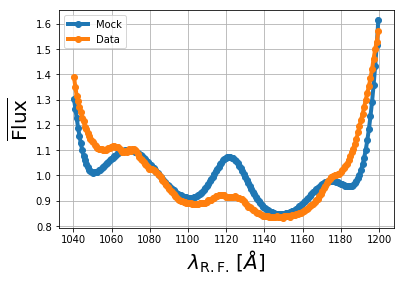

In [333]:
for name,path in all_delta_attributes.items():
    h = fitsio.FITS(path)
    loglam_rest = h[3]['LOGLAM_REST'][:]
    mean_cont = h[3]['MEAN_CONT'][:]
    w = h[3]['WEIGHT'][:]>0.
    loglam_rest = loglam_rest[w]
    mean_cont = mean_cont[w]
    plt.plot(10.**loglam_rest, mean_cont, linewidth=4,marker='o',label=name)
    h.close()
plt.xlabel(r'$\lambda_{\mathrm{R.F.}} \, [\AA]$', fontsize=20)
plt.ylabel(r'$\mathrm{\overline{Flux}}$', fontsize=20)
plt.legend(fontsize=10)
plt.grid()
plt.show()

### Let's look at the correction to the pipeline variance

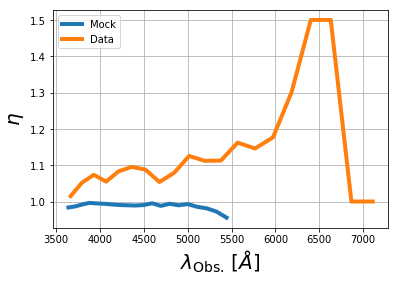

In [334]:
for name,path in all_delta_attributes.items():
    h = fitsio.FITS(path)
    loglam = h[2]['LOGLAM'][:]
    eta = h[2]['ETA'][:]
    w = h[2]['NB_PIXELS'][:]>0.
    loglam = loglam[w]
    eta = eta[w]
    plt.errorbar(10.**loglam, eta, linewidth=4,label=name)
    h.close()
plt.xlabel(r'$\lambda_{\mathrm{Obs.}} \, [\AA]$',fontsize=20)
plt.ylabel(r'$\eta$',fontsize=20)
plt.legend(fontsize=10)
plt.grid()
plt.show()

### Let's look at the Large Scale Structure variance

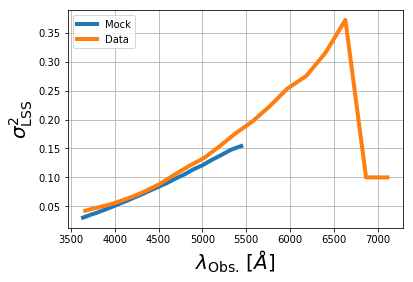

In [335]:
for name,path in all_delta_attributes.items():
    h = fitsio.FITS(path)
    loglam = h[2]['LOGLAM'][:]
    var_lss = h[2]['VAR_LSS'][:]
    w = h[2]['NB_PIXELS'][:]>0.
    loglam = loglam[w]
    var_lss = var_lss[w]
    plt.errorbar(10.**loglam, var_lss, linewidth=4,label=name)
    h.close()
plt.xlabel(r'$\lambda_{\mathrm{Obs.}} \, [\AA]$',fontsize=20)
plt.ylabel(r'$\sigma^{2}_{\mathrm{LSS}}$',fontsize=20)
plt.legend(fontsize=10)
plt.grid()
plt.show()

### Let's look at the contribution of the variation of the continuum

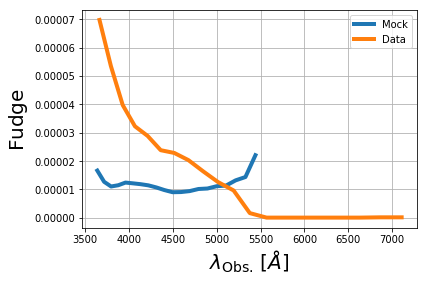

In [336]:
for name,path in all_delta_attributes.items():
    h = fitsio.FITS(path)
    loglam = h[2]['LOGLAM'][:]
    fudge = h[2]['FUDGE'][:]
    w = h[2]['NB_PIXELS'][:]>0
    loglam = loglam[w]
    fudge = fudge[w]
    plt.errorbar(10.**loglam, fudge, linewidth=4,label=name)
    h.close()
plt.xlabel(r'$\lambda_{\mathrm{Obs.}} \, [\AA]$',fontsize=20)
plt.ylabel(r'$\mathrm{Fudge}$',fontsize=20)
plt.legend(fontsize=10)
plt.grid()
plt.show()

# __The 1d auto-correlation__

To run the auto-correlation of pixels from the same forest, simply run the folowing
lines into your terminal

In [340]:
### Command to run the 1d auto-correlation
cmd = 'do_cf1d.py'
cmd += ' --in-dir '+mock['delta']
cmd += ' --out '+mock['cf1d']
print(cmd)

do_cf1d.py --in-dir /project/projectdirs/desi/mocks/lya_forest/picca/london/v4.0/quick-0.0/deltas/ --out /global/homes/h/hdumasde/Run_programs/igmhub/picca/CoLoRe_mocks/cf1d.fits.gz


Let's look at the variance and the correlation between pixels

In [341]:
### List of all the correlation to plot
all_cf1d = {'Mock':mock['cf1d'], 'Data':data['cf1d']}

### The variance of delta in the forest

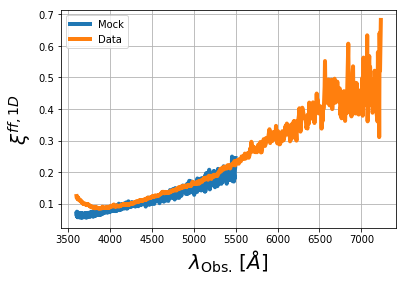

In [342]:
### The variance
for name,path in all_cf1d.items():
    h = fitsio.FITS(path)
    head = h[1].read_header() #- in the future replace '1' by '1DCOR'
    llmin = head['LLMIN']
    llmax = head['LLMAX']
    dll = head['DLL']
    n1d = int((llmax-llmin)/dll+1)
    x = sp.arange(0.,n1d)*dll+llmin
    y = h[1]['v1d'][:]
    w = h[1]['wv1d'][:]>0.
    x = x[w]
    y = y[w]
    plt.plot(10.**x,y,linewidth=4,label=name)
    h.close()
plt.xlabel(r'$\lambda_{\mathrm{Obs.}} \, [\AA] $',fontsize=20)
plt.ylabel(r'$\xi^{ff,1D}$',fontsize=20)
plt.legend(fontsize=10)
plt.grid()
plt.show()

### The normalized correlation in the forest

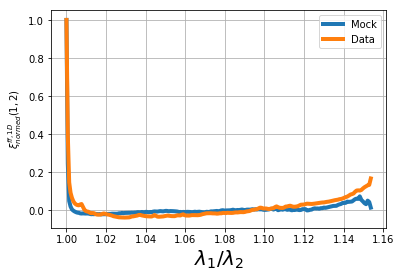

In [343]:
### The normalized correlation
for name,path in all_cf1d.items():
    h = fitsio.FITS(path)
    y = h[1]['c1d'][:] #- in the future replace '1' by '1DCOR'
    binsize = dll
    bins = sp.arange(y.size)
    x = sp.power(10,bins*binsize)
    w = h[1]['nc1d'][:]>0.
    x = x[w]
    y = y[w]
    plt.plot(x,y,linewidth=4,label=name)
    h.close()
plt.xlabel(r'$\lambda_{1}/\lambda_{2}$',fontsize=20)
plt.ylabel(r'$\xi^{ff,1D}_{normed}(1,2)$',fontsize=10)
plt.legend(fontsize=10)
plt.grid()
plt.show()